# Utilizando la estructura realizada sobre los random forest. Vamos a realizar el analisis por Bagging y Boosting

## Partimos de las variables seleccionadas para los procesos de randomForest

In [79]:
import pandas as pd
import numpy as np

In [80]:
# VARIABLES DEPENDIENTE DEL ENTORNO
user_code = 'u519914'
data_path = '/us/'+user_code+'/lava_iniciative/data/'

# Rutas de ficheros origen
select1_dataframe_csv = data_path + 'result/select1_dataframe.csv'

#Rutas de ficheros de salida 
results = data_path + 'result/'
boost_prediction_csv = results + 'BoostPrediction.csv'
bagging_prediction_csv = results + 'BaggingPrediction.csv'

In [3]:
#Carga del fichero con las variables pre-seleccionadas
df = pd.read_csv(select1_dataframe_csv,sep=";",decimal=".").fillna(0)
print df.shape
#for i in df.columns: print i

(3184, 100)


In [4]:
from sklearn.utils import shuffle
df = df[df['precios']!=0]
# Mezclamos el orden del dataframe para eliminar situaciones de sesgo a la hora de la eleccion del conjunto de datos de train and test
df = shuffle(df)

In [5]:
from sklearn.utils import shuffle
# Mezclamos el orden del dataframe para eliminar situaciones de sesgo a la hora de la eleccion del conjunto de datos de train and test
df = shuffle(df)

In [6]:
def printcolumns(df):
    for i in df.columns: print i

In [7]:
#printcolumns(df)

# 1. Definición de los métodos de clasificación

In [8]:
import sklearn as sk
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Para generación de gráficas
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def createRandomForest(X,y, maxdepth=None, estimators = 100, test_size = 0.3, showMetrics = False):
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = test_size)
    
    clf = RandomForestClassifier(n_estimators=estimators, max_depth=maxdepth)
    clf = clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    if showMetrics:
        print "train_score: %f" % train_score
        print "test score: %f" % test_score
        #print "cross val(mean): %f" % cross_val_score(clf, X, y, cv=10).mean()
        print sk.metrics.confusion_matrix(y_test, clf.predict(x_test))
        #showIterationProgress(clf, x_train, y_train, x_test, y_test)
    return clf, train_score, test_score

In [10]:
def createAdaBoost(X,y, learning_rate=1, estimators = 50, test_size = 0.3, showMetrics = False):
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = test_size)
    
    clf = AdaBoostClassifier(n_estimators=estimators, learning_rate=learning_rate)
    clf = clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    if showMetrics:
        print "train_score: %f" % train_score
        print "test score: %f" % test_score
        #print "cross val(mean): %f" % cross_val_score(clf, X, y, cv=10).mean()
        print sk.metrics.confusion_matrix(y_test, clf.predict(x_test))
        
        train_score = np.empty(len(clf.estimators_))
        test_score = np.empty(len(clf.estimators_))
        
        
        for i, scr in enumerate(clf.staged_score(x_test,y_test)):
            test_score[i] = scr

        for i, scr in enumerate(clf.staged_score(x_train,y_train)):
            train_score[i] = scr


        plt.plot(test_score)
        plt.plot(train_score)
        plt.legend(['test score', 'train score'])
        plt.show()
        
    return clf, train_score, test_score

In [11]:
def createGradBoost(X,y, max_depth=3, estimators = 50, test_size = 0.3, showMetrics = False):
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = test_size)
    
    clf = GradientBoostingClassifier(n_estimators=estimators, max_depth=max_depth)
    clf = clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    if showMetrics:
        print "train_score: %f" % train_score
        print "test score: %f" % test_score
        #print "cross val(mean): %f" % cross_val_score(clf, X, y, cv=10).mean()
        print sk.metrics.confusion_matrix(y_test, clf.predict(x_test))
        train_score = np.empty(len(clf.estimators_))
        test_score = np.empty(len(clf.estimators_))
        
        
        for i, pred in enumerate(clf.staged_decision_function(x_test)):
            test_score[i] = clf.loss_(y_test, pred)

        for i, pred in enumerate(clf.staged_decision_function(x_train)):
            train_score[i] = clf.loss_(y_train, pred)

        plt.plot(test_score)
        plt.plot(train_score)
        plt.legend(['test score', 'train score'])
        plt.show()
    return clf, train_score, test_score

In [12]:
def createBagging(X,y, base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, test_size = 0.3, showMetrics = False):
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = test_size)
    
    clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features)
    clf = clf.fit(x_train, y_train)
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    if showMetrics:
        print "train_score: %f" % train_score
        print "test score: %f" % test_score
        #print "cross val(mean): %f" % cross_val_score(clf, X, y, cv=10).mean()
        print sk.metrics.confusion_matrix(y_test, clf.predict(x_test))
    return clf, train_score, test_score

In [13]:
from sklearn.model_selection import GridSearchCV

def crossval_GBRT(X, y, test_size = 0.3):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size)
    learning_rate = range(1,11)
    learning_rate = [x/1000.0 for x in learning_rate] #best is 0.00001
    
    n_estimators = range(1,20)*10
    max_depth = range(1,10)
    
                  
    param_grid = {'n_estimators': n_estimators,
                  'max_depth':max_depth}
#'learning_rate': learning_rate,
             
    est = RandomForestClassifier()
    gs_cv = GridSearchCV(est, param_grid).fit(X_train, y_train)
    return gs_cv
    

In [16]:
# Funcion para presentar las variables de mayor relevancia
def showNFeaturesByImportance(decisor, min_rel=0.01):
    
    importances = decisor.feature_importances_
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    count = 0 
    for f in range(X.shape[1]):
        #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        print("%d. feature %d:%s (%f)" % (f + 1, indices[f],X.columns[indices[f]], importances[indices[f]]))
        if importances[indices[f]] < min_rel: break
        count += 1
    # Presentamos una gráfica con las features más relevantes
    # Plot the feature importances of the forest
    indices = indices[:count]
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(0,count), importances[indices],
           color="r", align="center")
    plt.xticks(range(0,count), indices)
    plt.xlim([-1, count])
    plt.show()

In [17]:
def reviewForest(X, y, stimators = 100, cross_val = 10, maxdepth=None):
    forest = RandomForestClassifier(n_estimators = stimators, max_depth = maxdepth)
    forest = forest.fit(X, y)
    print "score over train Data: " 
    print forest.score(X, y)
    print "Cross validation 20 iteraciones"
    print cross_val_score(forest, X, y, cv=cross_val).mean()
    showNFeaturesByImportance(forest,0.01)
    return forest

In [43]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [ ]:
# Calling Method 
plot_grid_search(pipe_grid.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')

# 1.1. Realizamos una segmentación del precio en 3 niveles

### Partimos del analisis realizado sobre los decision tree para limpiar variables

In [18]:
y = pd.qcut(df['precios'],[0.,0.25,0.75,1],[0,1,2])
X = df.drop(['precios','CBD1','CBD2','CBD3','id_sscc','CUSEC'], axis=1)

In [46]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
rfc = RandomForestClassifier(max_features= 'sqrt' ,n_estimators=50) 
param_grid = { 
    'n_estimators': [50,60,70,80,90,100],
    'max_depth': [5,6,7,8]
#    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print CV_rfc.best_params_

{'n_estimators': 100, 'max_depth': 8}


/DYA/da_tech/envs/curso-2016/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


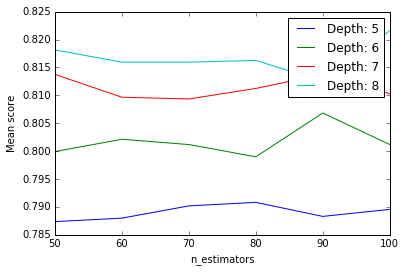

In [59]:
scores = [x[1] for x in CV_rfc.grid_scores_]
scores = np.array(scores).reshape(4, 6)

for ind, i in enumerate([5,6,7,8]):
    plt.plot([50,60,70,80,90,100], scores[ind], label='Depth: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Mean score')
plt.show()

In [123]:
forest_clf = createRandomForest(X,y, maxdepth=5, estimators = 100, test_size = 0.25, showMetrics = True)

train_score: 0.839196
test score: 0.793970
[[168  39   0]
 [ 37 325  27]
 [  0  61 139]]


In [21]:
forest_clf = createRandomForest(X,y, maxdepth=8, estimators = 70, test_size = 0.25, showMetrics = True)

train_score: 0.932161
test score: 0.831658
[[194  33   0]
 [ 23 339  22]
 [  0  56 129]]


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)
rfc = BaggingClassifier() 
param_grid = { 
    'n_estimators': [10,25,50,75],
    'max_samples': [0.5,0.75,1],
    'max_features': [10,20,30,40,50]
}
CV_bagc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_bagc.fit(X, y)
print CV_bagc.best_params_

{'max_features': 30, 'max_samples': 0.75, 'n_estimators': 75}


/DYA/da_tech/envs/curso-2016/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[[ 0.76538945  0.7986809   0.81187186  0.81030151]
 [ 0.77355528  0.8093593   0.81061558  0.82003769]
 [ 0.35018844  0.5         0.5         0.5       ]]
[[ 0.78077889  0.80810302  0.82443467  0.82129397]
 [ 0.79522613  0.81407035  0.82317839  0.82788945]
 [ 0.40012563  0.5         0.5         0.5       ]]
[[ 0.79051508  0.81061558  0.82380653  0.82223618]
 [ 0.8008794   0.8093593   0.82726131  0.83040201]
 [ 0.45006281  0.45006281  0.5         0.5       ]]
[[ 0.79742462  0.8156407   0.82066583  0.81909548]
 [ 0.79522613  0.8156407   0.81909548  0.82537688]
 [ 0.45006281  0.5         0.5         0.5       ]]
[[ 0.80025126  0.80590452  0.82192211  0.81972362]
 [ 0.8008794   0.81626884  0.82066583  0.82757538]
 [ 0.5         0.5         0.5         0.44974874]]


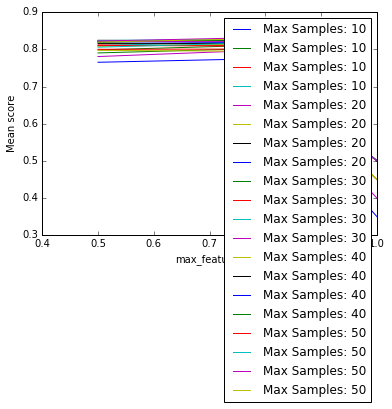

In [76]:
scores = [x[1] for x in CV_bagc.grid_scores_]
scores = np.array(scores).reshape(5, 3,4)

for ind, i in enumerate([10,20,30,40,50]):
    plt.plot([0.5,0.75,1], scores[ind], label='Max Samples: ' + str(i))
    print scores[ind]
plt.legend()
plt.xlabel('max_features')
plt.ylabel('Mean score')
plt.show()

In [25]:
bagging_clf = createBagging(X,y, n_estimators=50, max_samples=0.75, max_features=30, test_size = 0.25, showMetrics = True)

train_score: 0.999162
test score: 0.829146
[[186  21   0]
 [ 30 331  37]
 [  0  48 143]]


train_score: 0.745812
test score: 0.706030
[[192  25   2]
 [ 71 223  82]
 [  0  54 147]]


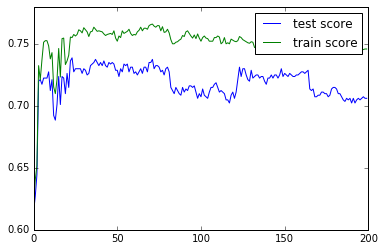

In [29]:
boosting_clf = createAdaBoost(X,y, learning_rate=0.5, estimators = 200, test_size = 0.25, showMetrics = True)

train_score: 0.753350
test score: 0.729899
[[144  44   1]
 [ 33 302  74]
 [  0  63 135]]


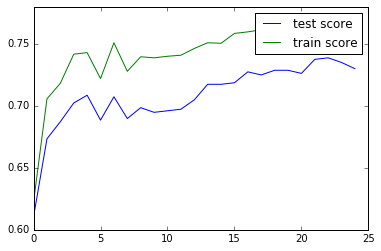

In [30]:
boosting_clf = createAdaBoost(X,y, learning_rate=0.5, estimators = 25, test_size = 0.25, showMetrics = True)

train_score: 0.999581
test score: 0.826633
[[166  29   0]
 [ 26 340  39]
 [  0  44 152]]


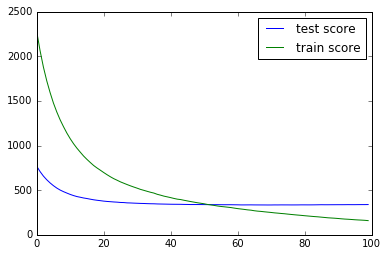

In [31]:
Grading_clf = createGradBoost(X,y, max_depth=5, estimators = 100, test_size = 0.25, showMetrics = True)

train_score: 0.930486
test score: 0.807789
[[169  32   1]
 [ 30 337  48]
 [  1  41 137]]


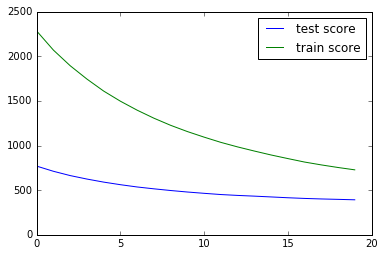

In [32]:
Grading_clf = createGradBoost(X,y, max_depth=5, estimators = 20, test_size = 0.25, showMetrics = True)

Se observa que a partir de 20 iteraciones, la prediccion no mejora

### Sin entrar más a detalle, vamos a revisar las "features" a ver si coinciden

Feature ranking:
1. feature 7:estudios_tercer_grado_perc (0.099189)
2. feature 52:CBD_min (0.068070)
3. feature 56:es_barsandrestaurants (0.043211)
4. feature 46:2km_TURISMO (0.033487)
5. feature 80:es_health_count (0.029440)
6. feature 5:estudios_primer_grado_perc (0.028585)
7. feature 4:sin_estudios_perc (0.026491)
8. feature 32:2km_hoteles (0.026123)
9. feature 6:estudios_segundo_grado_perc (0.025396)
10. feature 89:es_transportation_count (0.022551)
11. feature 66:es_otherservices (0.022315)
12. feature 63:es_hotelservices (0.019905)
13. feature 61:es_health (0.017077)
14. feature 72:es_wellnessandbeauty (0.016639)
15. feature 91:es_wellnessandbeauty_count (0.016576)
16. feature 29:2km_farmacias (0.016495)
17. feature 82:es_hotelservices_count (0.016103)
18. feature 44:2km_CULTURA (0.015211)
19. feature 92:Tot_op (0.014689)
20. feature 2:nacionalidad_extranjera_perc (0.011396)
21. feature 39:2km_polideportivos (0.011293)
22. feature 28:2km_colegios (0.011192)
23. feature 58:es_cont

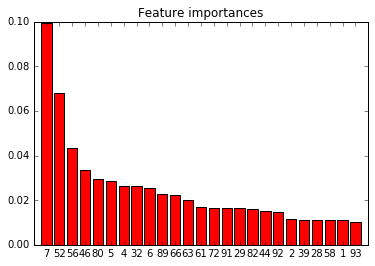

In [33]:
showNFeaturesByImportance(forest_clf[0])

Feature ranking:
1. feature 52:CBD_min (0.160000)
2. feature 7:estudios_tercer_grado_perc (0.120000)
3. feature 0:edad_16anos_perc (0.080000)
4. feature 4:sin_estudios_perc (0.080000)
5. feature 15:viviendas_menos_75m2_perc (0.080000)
6. feature 77:es_contents_count (0.040000)
7. feature 39:2km_polideportivos (0.040000)
8. feature 33:2km_monumentos (0.040000)
9. feature 57:es_bbva (0.040000)
10. feature 61:es_health (0.040000)
11. feature 63:es_hotelservices (0.040000)
12. feature 20:viviendas_menos_4habitaciones_perc (0.040000)
13. feature 17:viviendas_menos_150m2_perc (0.040000)
14. feature 68:es_sportsandtoys (0.040000)
15. feature 6:estudios_segundo_grado_perc (0.040000)
16. feature 5:estudios_primer_grado_perc (0.040000)
17. feature 10:viviendas_vacias_perc (0.040000)
18. feature 2:nacionalidad_extranjera_perc (0.000000)


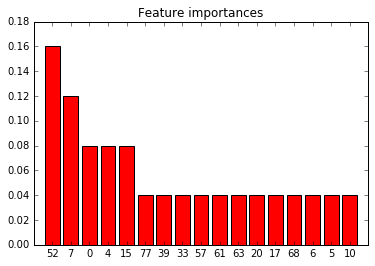

In [34]:
showNFeaturesByImportance(boosting_clf[0])

Feature ranking:
1. feature 7:estudios_tercer_grado_perc (0.228870)
2. feature 52:CBD_min (0.212774)
3. feature 89:es_transportation_count (0.050179)
4. feature 62:es_home (0.017773)
5. feature 54:es_auto (0.016637)
6. feature 69:es_tech (0.015606)
7. feature 91:es_wellnessandbeauty_count (0.014700)
8. feature 2:nacionalidad_extranjera_perc (0.014340)
9. feature 15:viviendas_menos_75m2_perc (0.013790)
10. feature 28:2km_colegios (0.013542)
11. feature 35:2km_parques (0.013402)
12. feature 80:es_health_count (0.012858)
13. feature 16:viviendas_menos_105m2_perc (0.012792)
14. feature 5:estudios_primer_grado_perc (0.012713)
15. feature 12:viviendas_alquiler_perc (0.012603)
16. feature 64:es_hyper (0.012207)
17. feature 61:es_health (0.012112)
18. feature 1:edad_64_anos_perc (0.011919)
19. feature 24:hogares_familias_perc (0.011816)
20. feature 56:es_barsandrestaurants (0.011373)
21. feature 63:es_hotelservices (0.010870)
22. feature 29:2km_farmacias (0.009608)


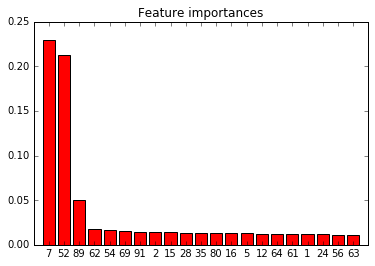

In [35]:
showNFeaturesByImportance(Grading_clf[0])

# Vamos a realizar una comparación un poco más trabajada. Dada la aleatoriedad de los modelos en cuanto a la forma de generar los procesos de decisión. 

DT: 0.744031 (0.015407)
RF: 0.806851 (0.017180)
BAG: 0.797430 (0.026619)
AdaBoost: 0.725826 (0.017589)
GrBoost: 0.812819 (0.015719)


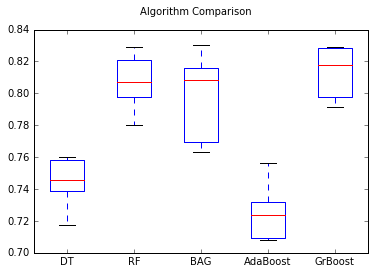

In [37]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('BAG', BaggingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('GrBoost', GradientBoostingClassifier()))
#models.append(('SVM_l', SVC(kernel = 'linear',C=1,tol=0.1)))
#models.append(('SVM', SVC(kernel = 'rbf',C=1,tol=0.1)))
#models.append(('SVM_2', SVC(kernel = 'rbf',C=0.8,tol=0.2)))
#models.append(('ML', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,50,30), random_state=1,learning_rate_init=0.001,max_iter=200)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

DT: 0.769165 (0.028657)
RF: 0.817212 (0.014428)
BAG: 0.820355 (0.020284)
AdaBoost: 0.755971 (0.018960)
GrBoost: 0.819727 (0.018043)


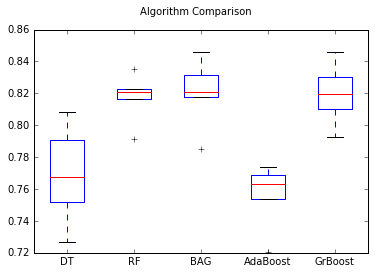

In [41]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('DT', DecisionTreeClassifier(max_depth=6)))
models.append(('RF', RandomForestClassifier(max_depth=8, n_estimators = 70)))
models.append(('BAG', BaggingClassifier(n_estimators=50, max_features=30, max_samples=0.75)))
models.append(('AdaBoost', AdaBoostClassifier(learning_rate=0.5, n_estimators=25)))
models.append(('GrBoost', GradientBoostingClassifier(max_depth=7, n_estimators = 20)))
#models.append(('SVM_l', SVC(kernel = 'linear',C=1,tol=0.1)))
#models.append(('SVM', SVC(kernel = 'rbf',C=1,tol=0.1)))
#models.append(('SVM_2', SVC(kernel = 'rbf',C=0.8,tol=0.2)))
#models.append(('ML', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,50,30), random_state=1,learning_rate_init=0.001,max_iter=200)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Basic score 0.855000
Calibrated score 0.790000
Log-loss of
 * uncalibrated classifier trained on 75 porciento datapoints: 0.387 
 * classifier trained on 50 porciento datapoints and calibrated on 25 porciento datapoint: 0.529


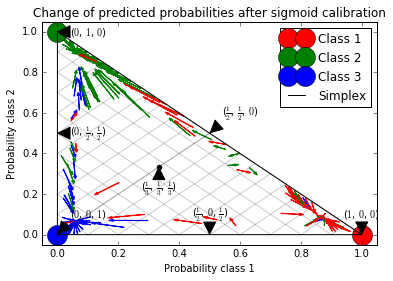

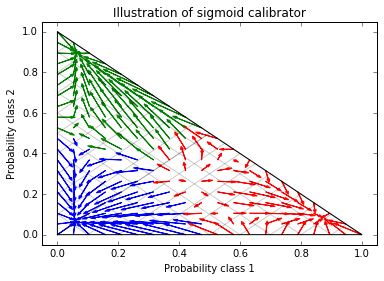

In [59]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

SEED = 2000
X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.4, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=50, max_depth=5)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
print ("Basic score %f" % clf.score(X_test,y_test))
score = log_loss(y_test, clf_probs)

# Train random forest classifier, calibrate on validation data and evaluate
# on test data
clf = RandomForestClassifier(n_estimators=50, max_depth=5)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
print ("Calibrated score %f" % sig_clf.score(X_test,y_test))
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)

# Plot changes in predicted probabilities via arrows
plt.figure(0)
colors = ["r", "g", "b"]
for i in range(clf_probs.shape[0]):
    plt.arrow(clf_probs[i, 0], clf_probs[i, 1],
              sig_clf_probs[i, 0] - clf_probs[i, 0],
              sig_clf_probs[i, 1] - clf_probs[i, 1],
              color=colors[y_test[i]], head_width=1e-2)

# Plot perfect predictions
plt.plot([1.0], [0.0], 'ro', ms=20, label="Class 1")
plt.plot([0.0], [1.0], 'go', ms=20, label="Class 2")
plt.plot([0.0], [0.0], 'bo', ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

# Annotate points on the simplex
plt.annotate(r'($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)',
             xy=(1.0/3, 1.0/3), xytext=(1.0/3, .23), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.plot([1.0/3], [1.0/3], 'ko', ms=5)
plt.annotate(r'($\frac{1}{2}$, $0$, $\frac{1}{2}$)',
             xy=(.5, .0), xytext=(.5, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $\frac{1}{2}$, $\frac{1}{2}$)',
             xy=(.0, .5), xytext=(.1, .5), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($\frac{1}{2}$, $\frac{1}{2}$, $0$)',
             xy=(.5, .5), xytext=(.6, .6), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $0$, $1$)',
             xy=(0, 0), xytext=(.1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($1$, $0$, $0$)',
             xy=(1, 0), xytext=(1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $1$, $0$)',
             xy=(0, 1), xytext=(.1, 1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
# Add grid
plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Change of predicted probabilities after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.legend(loc="best")

print("Log-loss of")
print(" * uncalibrated classifier trained on 75 porciento datapoints: %.3f "
      % score)
print(" * classifier trained on 50 porciento datapoints and calibrated on "
      "25 porciento datapoint: %.3f" % sig_score)

# Illustrate calibrator
plt.figure(1)
# generate grid over 2-simplex
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

calibrated_classifier = sig_clf.calibrated_classifiers_[0]
prediction = np.vstack([calibrator.predict(this_p)
                        for calibrator, this_p in
                        zip(calibrated_classifier.calibrators_, p.T)]).T
prediction /= prediction.sum(axis=1)[:, None]

# Plot modifications of calibrator
for i in range(prediction.shape[0]):
    plt.arrow(p[i, 0], p[i, 1],
              prediction[i, 0] - p[i, 0], prediction[i, 1] - p[i, 1],
              head_width=1e-2, color=colors[np.argmax(p[i])])
# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Illustration of sigmoid calibrator")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()

# Descargamos los datos de grading a CSV

In [91]:

clf = Grading_clf[0]
df_final = df
df_final['nivel_precio'] = y
df_final['prediction'] = clf.predict(X)
#df_final['proba'] = clf.predict_proba(X)
df_final['acierto'] = df_final['prediction'] == y
#df_final['id_sscc'] = df_final['id_sscc'].apply(lambda x: "%010d" % + x)
print df_final.shape
print df_final.head(2)
df_final.to_csv(boost_prediction_csv, sep=";",decimal=".")
print boost_prediction_csv

(3184, 103)
         id_sscc  edad_16anos_perc  edad_64_anos_perc  \
2534  0801902173          0.052632           0.304511   
474   2807905045          0.094444           0.208333   

      nacionalidad_extranjera_perc  casados_perc  sin_estudios_perc  \
2534                      0.139098      0.345865           0.056391   
474                       0.172222      0.352778           0.063889   

      estudios_primer_grado_perc  estudios_segundo_grado_perc  \
2534                    0.154135                     0.567669   
474                     0.094444                     0.402778   

      estudios_tercer_grado_perc  viviendas_principales_perc   ...     \
2534                    0.172932                    1.000000   ...      
474                     0.347222                    0.836735   ...      

      es_tech_count  es_transportation_count  es_travel_count  \
2534          143.0                    171.0             34.0   
474            96.0                    162.0            

In [92]:
clf = bagging_clf[0]
df_final = df
df_final['nivel_precio'] = y
df_final['prediction'] = clf.predict(X)
#df_final['proba'] = clf.predict_proba(X)
df_final['acierto'] = df_final['prediction'] == y
#df_final['id_sscc'] = df_final['id_sscc'].apply(lambda x: "%010d" % + x)
print df_final.shape
print df_final.head(2)
df_final.to_csv(bagging_prediction_csv, sep=";",decimal=".")
print bagging_prediction_csv

(3184, 103)
         id_sscc  edad_16anos_perc  edad_64_anos_perc  \
2534  0801902173          0.052632           0.304511   
474   2807905045          0.094444           0.208333   

      nacionalidad_extranjera_perc  casados_perc  sin_estudios_perc  \
2534                      0.139098      0.345865           0.056391   
474                       0.172222      0.352778           0.063889   

      estudios_primer_grado_perc  estudios_segundo_grado_perc  \
2534                    0.154135                     0.567669   
474                     0.094444                     0.402778   

      estudios_tercer_grado_perc  viviendas_principales_perc   ...     \
2534                    0.172932                    1.000000   ...      
474                     0.347222                    0.836735   ...      

      es_tech_count  es_transportation_count  es_travel_count  \
2534          143.0                    171.0             34.0   
474            96.0                    162.0            